# Practice plotting

Here, we'll do some exploratory data analysis (EDA) of the pitchfx data. EDA is a quick and dirty way to determine what is in your dataset. There are many ways to do this, and plotting the data is a key way of looking at the data. Note that this is mainly practice in plotting a bunch of different types of figures.

Begin by importing the necessary libraries and specifying a name for the database you want to create.

In [133]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import subprocess

# specify database name
dbname = "../Dat/test.db"

We'll work with a subset of the dataset when performing EDA. Specifically, we will look at the pitches from a single pitcher. Here, it will be CC Sabathia.

In [5]:
# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

In [11]:
# get specific pitcher info
query = """SELECT DISTINCT pitchfx.* 
    FROM pitchfx
    JOIN events ON (pitchfx.game_id=events.game_id
        AND pitchfx.prev_event=events.event_id)
    WHERE events.pitcher_id=(SELECT player_id
        FROM players
        WHERE players.player_first='CC'
            AND players.player_last='Sabathia')
    ORDER BY game_id, pitch_num"""
df = pd.read_sql_query(query, db)
df.head()

,game_id,pitch_num,at_bat,time,prev_event,description,outcome,pre_balls,post_balls,pre_strike,...,vz0,ax,ay,az,break_y,break_angle,break_length,spin_dir,spin_rate,pitch_type
0,233762,3,1,NaN,0,Foul,S,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,233762,4,1,NaN,0,Called Strike,S,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,233762,5,1,NaN,0,"In play, out(s)",X,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,233762,9,2,NaN,1,Ball,B,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,233762,10,2,NaN,1,Ball,B,1,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


### Printed summaries of data

One of the first things you can do is to get a typed summary of the data set. We can do this in pandas, which has similar functions as in R. The *describe* function in pandas is similar to the *summary* function in R. Note that function only returns quantitative variables.

In [81]:
# print out summary of pandas dataframe
#df.describe()

# transpose it to see all the stats
df.describe().transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
game_id,3814,NaN,NaN,NaN,235021,712.015,233762,234443,235024,235628,236174
pitch_num,3814,NaN,NaN,NaN,238.573,148.516,3,110.25,232,354,605
at_bat,3814,NaN,NaN,NaN,31.0309,18.832,1,14,31,46,79
time,3554,NaN,NaN,NaN,180312,28796.2,130559,150133,192856,203255,224150
prev_event,3814,NaN,NaN,NaN,40.2037,26.1104,0,17,39,59,107
description,3814,15,Ball,1227,NaN,NaN,NaN,NaN,NaN,NaN,NaN
outcome,3814,3,S,1824,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pre_balls,3814,NaN,NaN,NaN,0.809386,0.930079,0,0,1,1,3
post_balls,3814,NaN,NaN,NaN,1.14604,1.00061,0,0,1,2,4
pre_strike,3814,NaN,NaN,NaN,0.900105,0.828761,0,0,1,2,3


Note that you can also look at the stats for a single feature. Here, we'll look at *spin rate*.

In [19]:
# show stats for spin rate
df['spin_rate'].describe()

count    3554.000000
mean     1931.415651
std       585.648138
min        43.628000
25%      1601.862250
50%      2028.085500
75%      2330.002250
max      3523.456000
Name: spin_rate, dtype: float64

Note that you can also store data in a different variable name and perform similar summary commands. Here, we will look at the percentiles (specifically the 0.1 and 0.5 percentile). The 50% percentile should match the median.

In [40]:
# store spin rate in a different variable
spin_rate = df["spin_rate"]
spin_rate.quantile([0.1, 0.5])

0.1    1042.3263
0.5    2028.0855
Name: spin_rate, dtype: float64

### Boxplots

Boxplots are common when visualizing quartile information. We'll stay with *spin rate* for our boxplot. Before plotting the data, we'll need to remove the nans.

Note that when extracting a single column from a dataframe, the column is now a *series* object. The series should be converted into a numpy array if plotting from matplotlib and not pandas (here we are plotting directly from a pandas object).

The red line is the median, the edges of the box are the 25% and 75% quartiles, and the the lines below and above the box correspond to some factor (*whis* in the arguments) multiplied by the interquartile range (Q3-Q1). It is meant to help identify outliers.

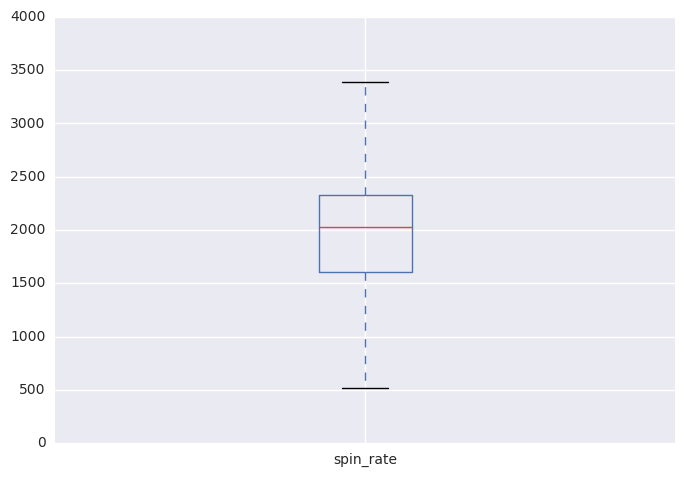

In [62]:
# remove nans
spin_rate = spin_rate.dropna()

# create boxplot
#plt.boxplot(spin_rate.as_matrix(), whis=1.5)
spin_rate.plot.box(whis=1.5)
plt.show()

Now, let's create boxplots of velocity sorted by pitch types.

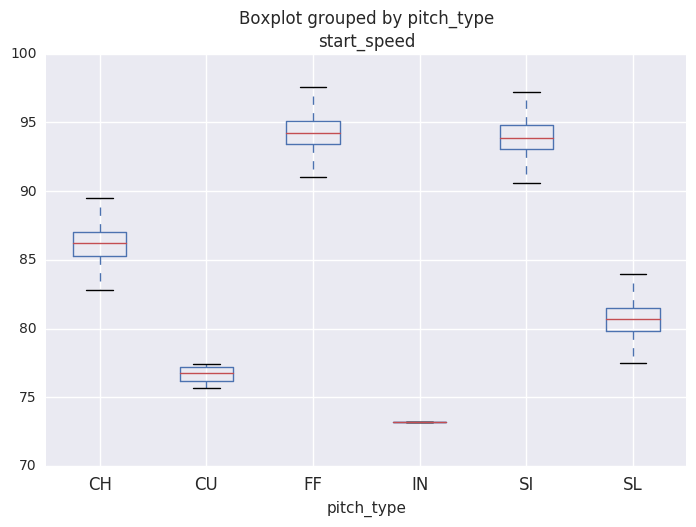

In [103]:
# create plot
df.boxplot(column="start_speed", by="pitch_type")
plt.show()

As we can see, Sabathia's fastball has the highest starting velocity, followed by his sinker, change-up, slider, and cutter.

Next, we'll look at how horizontal movement in inches (pfx_x) varies with pitch type.

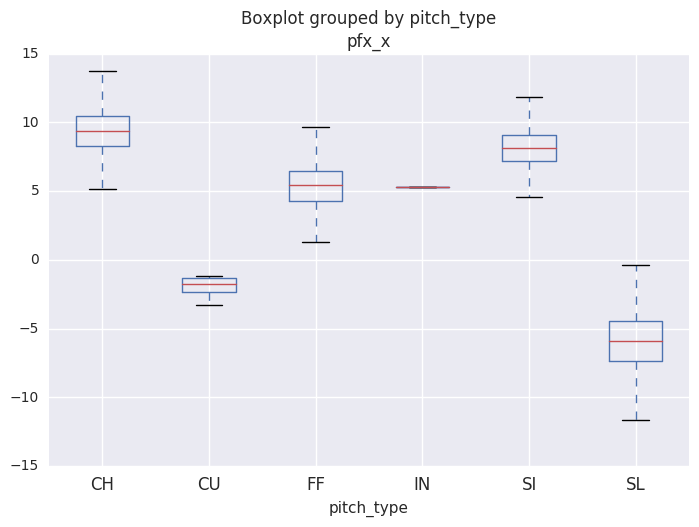

In [134]:
# create plot
df.boxplot(column="pfx_x", by="pitch_type")
plt.show()

As we can see, horizontal movement varies dramatically between sliders and changes-ups. Perhaps surprisingly, data suggests that Sabathia's slider has less horizontal movement than his change-up. It is assumed that, from the hitter's and catcher's perspective, negative values correspond to movement right to left and positive values correspond to movement left to right (based on Sabathia's handedness and the natural break of the slider).

Now let's look at vertical movement.

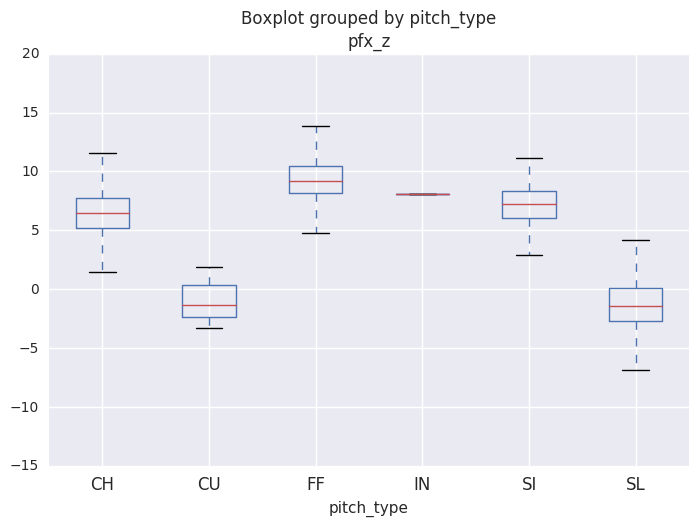

In [135]:
# create plot
df.boxplot(column="pfx_z", by="pitch_type")
plt.show()

We see that many pitches have "upward" movement, which doesn't make sense. However, given the way movement is defined, this can make sense. For example, most pitches, with curveballs being the main exception, have some backspin, which causes them not to drop as much as a spinless pitch (https://www.beyondtheboxscore.com/2009/4/17/841366/understanding-pitch-f-x-graphs). Note that again, sliders and change-ups are well separated from each other, but many pitches have positive vertical movement.

We'll look more closely at how often each of these pitches is thrown in a later section.

### Histograms

Next, we'll create a histogram of the same *spin_rate* data. We'll use *matplotlib* directly here. We'll show the effects of plotting histograms with different bin sizes side by side.

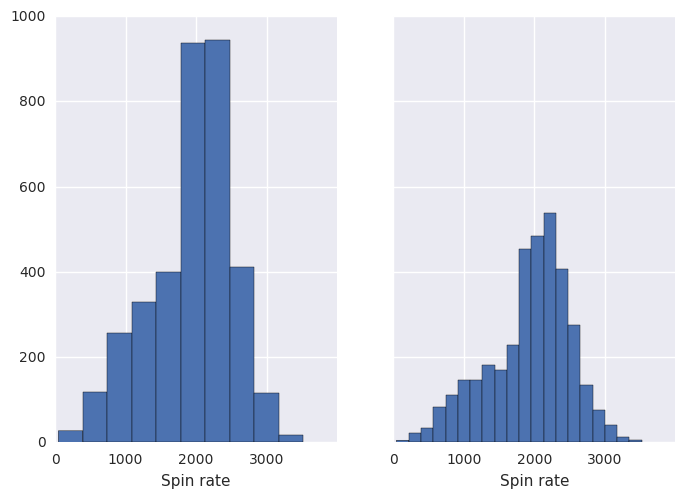

In [69]:
# convert series data to numpy array before plotting
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True) # share y-axis to show difference in values
ax1.hist(spin_rate.as_matrix())
ax1.set_xlabel("Spin rate")
ax1.set_xticks(np.arange(0, 4000, 1000)) 
ax2.hist(spin_rate.as_matrix(), bins=20)
ax2.set_xlabel("Spin rate")
ax2.set_xticks(np.arange(0, 4000, 1000)) 
plt.show()

We can also use seaborn to creat histograms with rug plots below. The rug plot is a fine-grain overview of the data, as opposed to a histogram, which bins the data. However, with so many data points the rug plot is not too useful. Note that the y-axis is normalized by default, as this is a distribution.

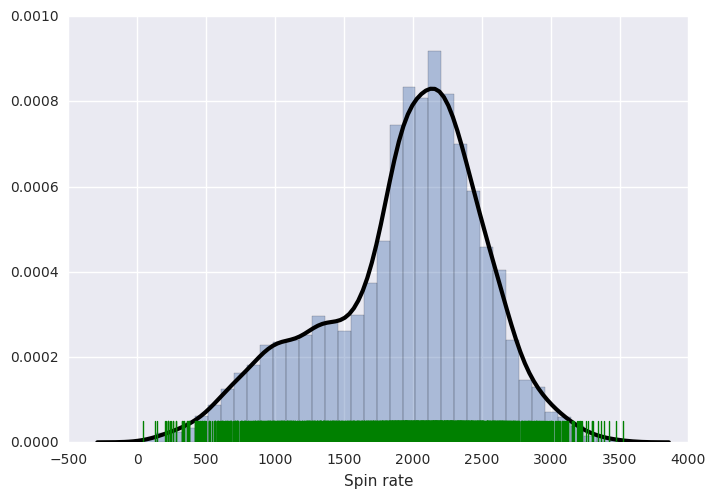

In [80]:
fig, ax = plt.subplots()
sns.distplot(spin_rate.as_matrix(), rug=True, hist=True, rug_kws={"color": "g"},
    kde_kws={"color": "k", "lw": 3})
ax.set_xlabel("Spin rate")
plt.show()

### Bar charts

We will now create a bar chart of all the pitch types thrown by CC Sabathia. First, let's get a summary of the pitch type information.

In [85]:
# describe pitch type information
df["pitch_type"].describe()

count     3554
unique       6
top         FF
freq      1489
Name: pitch_type, dtype: object

There are NaNs in the data, so let's clean them out and put them in a new variable name.

In [89]:
pitch_type = df["pitch_type"].dropna()

Next, let's create a bar plot of all the pitch types.

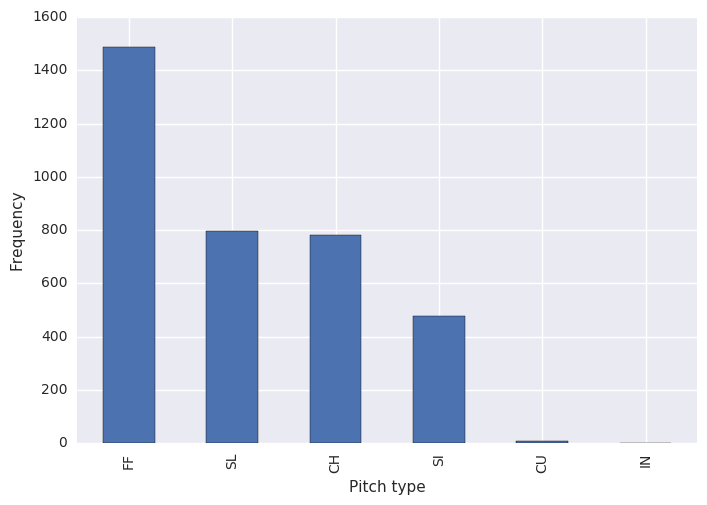

In [101]:
fig, ax = plt.subplots()
pitch_type.value_counts().plot(ax=ax, kind="bar")
ax.set_xlabel("Pitch type")
ax.set_ylabel("Frequency")
plt.show()

We can see that Sabathia complements his four-seam fastball with a slider, change-up, and sinker. There are a few pitches classified as cutters, but they are unlikely to actually be cutters given how infrequent they are throughout the season.

### Scatter plots

Here, we'll look at the raw data through scatter plots of various measurements. First, we'll pull up a summary of the pitchfx parameters that are available.

In [143]:
# get variable names from pitch fx with data types
print(*[df.dtypes], sep="\n")

game_id           int64
pitch_num         int64
at_bat            int64
time            float64
prev_event        int64
description      object
outcome          object
pre_balls         int64
post_balls        int64
pre_strike        int64
post_strike       int64
start_speed     float64
end_speed       float64
sz_top          float64
sz_bot          float64
pfx_x           float64
pfx_z           float64
px              float64
pz              float64
x               float64
y               float64
x0              float64
y0              float64
z0              float64
vx0             float64
vy0             float64
vz0             float64
ax              float64
ay              float64
az              float64
break_y         float64
break_angle     float64
break_length    float64
spin_dir        float64
spin_rate       float64
pitch_type       object
dtype: object


Most of these variables are going to be useful for classifying pitches. However, not all of them will be useful. Specifically, any variable not directly related to the trajectory of the ball. Therefore, we will chop off the first eleven variables, which have mostly to do with the times and situations at which the pitch was thrown. For a description of each of the features, have a look at:  https://fastballs.wordpress.com/category/pitchfx-glossary.

In [108]:
# create truncated pitchfx data frame
pdf = df.iloc[:, 11:]

Now we have a smaller data frame with fewer features. Let make a scatter plots of all these variables to see if there are any clear trends. Note that we will drop all rows containing NaNs to make the analysis easier. Typically where there are NaNs, it means that there was no measurment made of the pitch trajectory information. Therefore, we drop the entire row. We will also drop the last column, which is the pitch classification from MLB.

Here, we will plot all features but only 100 pitches.

/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=50.0, right=50.0
  'left=%s, right=%s') % (left, right))
/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=50.0, top=50.0
  'bottom=%s, top=%s') % (bottom, top))


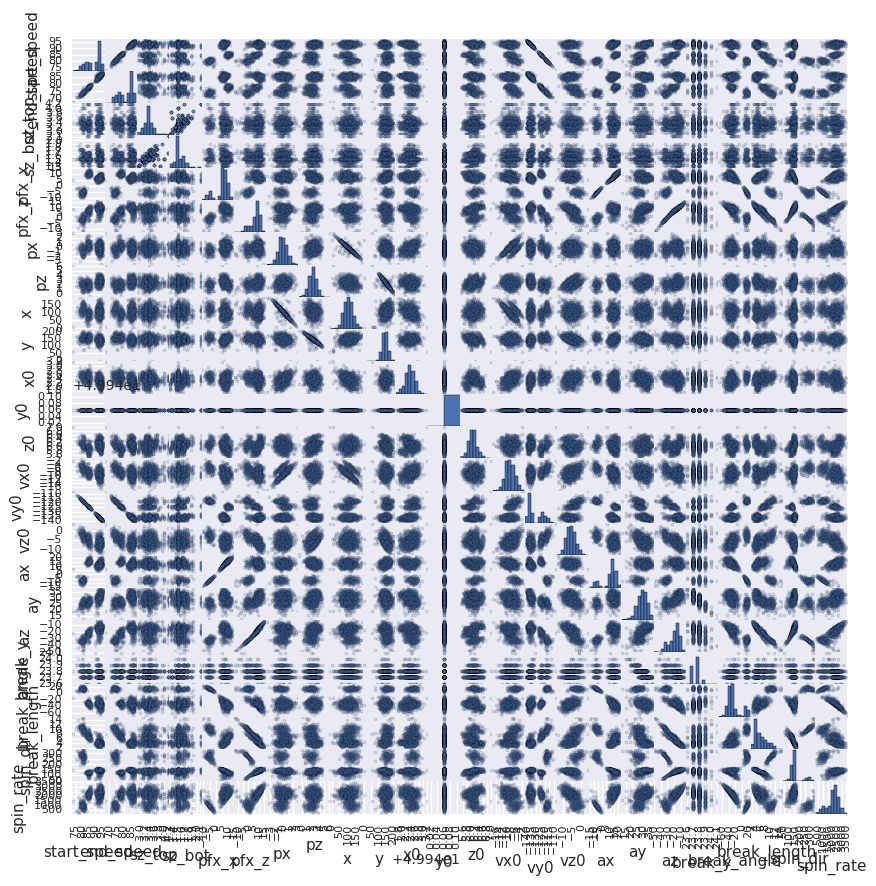

In [132]:
#pd.scatter_matrix(pdf.iloc[:100, :-1].dropna(axis=0, how='all'), alpha=0.2, figsize=(10, 10))
pd.scatter_matrix(pdf.iloc[:1000, :-1].dropna(axis=0, how='all'), alpha=0.2, figsize=(10, 10))
plt.show()

There is a lot of information in this scatter matrix, and it's difficult to pick out certain trends. However, we will try to explain some of what we see.

1) yo and break_y seem to be variables with a small spread of values. The former is the distance in feet from home plate where the PITCHf/x system is set to measure the initial parameters, and it is typically fixed after the year 2007. The latter is the distance in feet from home plate to the point in the pitch trajectory where the pitch achieved its greatest deviation from the straight line path between the release point and the front of home plate. This trait is potentially a fixed value for each game/stadium and does not appear to be very insightful.

2) There are very strong linear trends amongst certain features. Among them are x and px and y and pz. All these features are related to the location of the ball crossing the plate, with x and y tied to the old location system and px and pz related to the pitchfx system. Additionally, there seem to be strong trends between ax and pfx_x and az and pfx_z. This suggets that movement (in inches) is tied to acceleration (in ft/s), which is not surprising. Also, there is a strong correlation between start_speed and vy0, which is not surprising given that they are measuring speeds toward the plate.

3) There appears to be certain features that produce distinct clusters. For instance, end_speed and spin_rate, end_speed and pfx_x (horizontal movement), and end_speed and break_angle. These might be useful features when attempting to classify pitch types.

Let's focus on some of the more interesting plots. From point number 3, it seems that useful parameters to look at are end_speed, spin_rate, and pfx_x (horizontal movement). Let's put all of these into one crossplot.

In [ ]:
# 

### Pitch clustering